# 0 Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection

from IPython.core.display import display, HTML
from IPython.display import Image

## 0.2 Helper Functions

In [2]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
df_raw = pd.read_csv( '../data/raw/churn.csv')

### Columns Description



RowNumber: The column number

CustomerID: Customer's unique identifier

Surname: Customer's surname.

CreditScore: The customer's Credit score for the consumer market.

Geography: The country where the customer resides.

Gender: The customer's gender.

Age: The age of the customer.

Tenure: Number of years the client has been active.

Balance: Monetary value that the customer has in their bank account.

NumOfProducts: The number of products purchased by the customer at the bank.

HasCrCard: Indicates whether or not the customer has a credit card.

IsActiveMember: Indicates if the customer made at least one bank account transaction within 12 months.

EstimateSalary: Estimate of the customer's monthly salary.

Exited: Indicates whether or not the client is in Churn.

# 1. Data Description

## 1.1 Rename Columns

In [87]:
df1 = df_raw.copy()

# saving raw columns name
# cols_old = list(df_raw.columns)
cols_old = ['RowNumber','CustomerId','Surname','CreditScore','Geography','Gender','Age','Tenure',
            'Balance','NumOfProducts','HasCrCard','ActiveMember','Salary','Exited']


# Converting cols to snakecase
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map( snake_case, cols_old) )

# Renaming
df1.columns = cols_new


## 1.2 Data Dimensions

In [88]:
print( 'Number of Rows: {:,}'.format(df1.shape[0] ) )
print( 'Number of Cols: {}'.format(df1.shape[1] ) )

Number of Rows: 10,000
Number of Cols: 14


## 1.3 Data Types

In [90]:
df1.dtypes

row_number           int64
customer_id          int64
surname             object
credit_score         int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
num_of_products      int64
has_cr_card          int64
active_member        int64
salary             float64
exited               int64
dtype: object

## 1.4 NA Check

In [91]:
df1.isna().sum()

row_number         0
customer_id        0
surname            0
credit_score       0
geography          0
gender             0
age                0
tenure             0
balance            0
num_of_products    0
has_cr_card        0
active_member      0
salary             0
exited             0
dtype: int64

## 1.5 NA Fillout

## 1.6 Changing Data Types

## 1.8 Data Integrity Check

In [92]:
df1.nunique()
# No repeated customer_id

row_number         10000
customer_id        10000
surname             2932
credit_score         460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
num_of_products        4
has_cr_card            2
active_member          2
salary              9999
exited                 2
dtype: int64

In [86]:
df1.sample(5, random_state = 42)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [26]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [42]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.kurtosis() ).T
d8 = pd.DataFrame( num_att.skew() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
row_number,1.00,"10,000.00","9,999.00","5,000.50","5,000.50","2,886.90",-1.20,0.00
customer_id,"15,565,701.00","15,815,690.00","249,989.00","15,690,940.57","15,690,738.00","71,936.19",-1.20,0.00
credit_score,350.00,850.00,500.00,650.53,652.00,96.65,-0.43,-0.07
age,18.00,92.00,74.00,38.92,37.00,10.49,1.40,1.01
tenure,0.00,10.00,10.00,5.01,5.00,2.89,-1.17,0.01
balance,0.00,"250,898.09","250,898.09","76,485.89","97,198.54","62,397.41",-1.49,-0.14
num_of_products,1.00,4.00,3.00,1.53,1.00,0.58,0.58,0.75
has_cr_card,0.00,1.00,1.00,0.71,1.00,0.46,-1.19,-0.90
is_active_member,0.00,1.00,1.00,0.52,1.00,0.50,-2.00,-0.06
estimated_salary,11.58,"199,992.48","199,980.90","100,090.24","100,193.91","57,510.49",-1.18,0.00


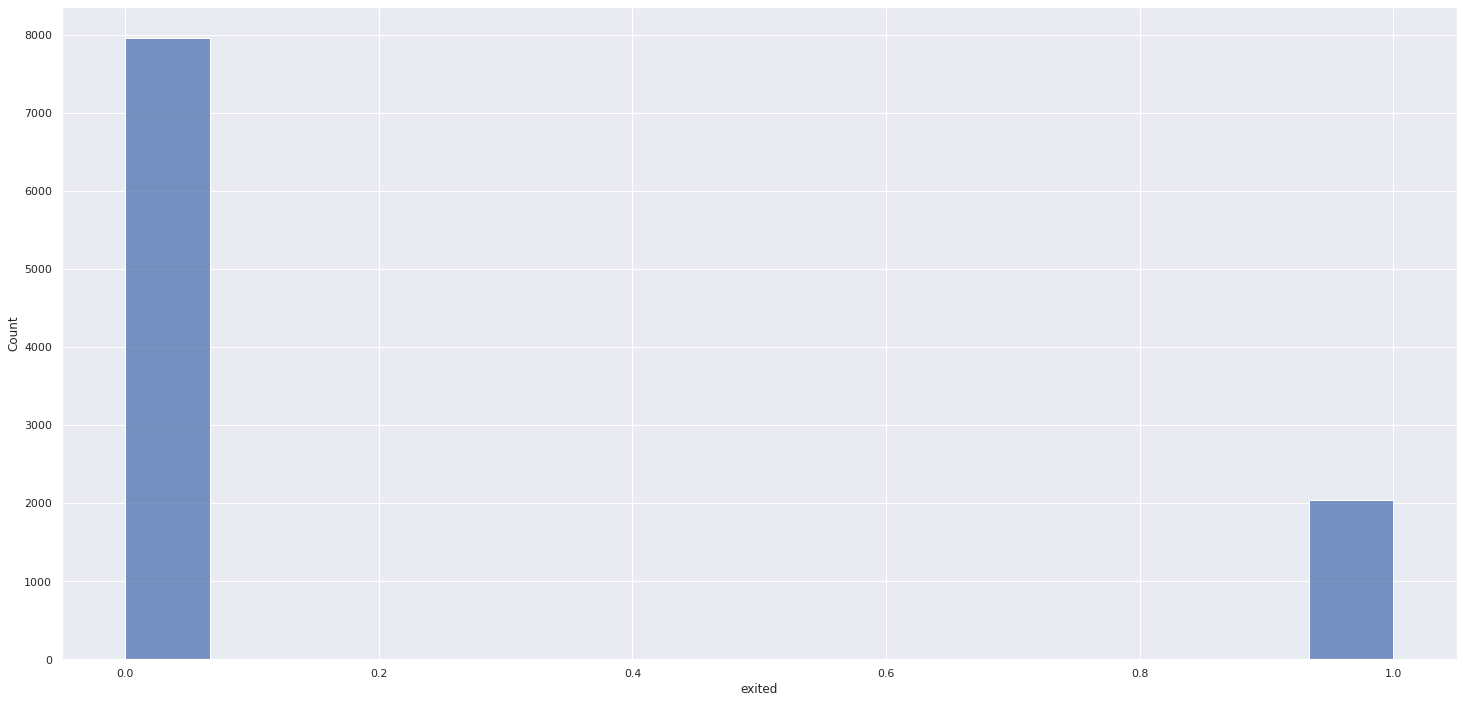

In [57]:
# Interest Variable
sns.histplot(data=df1, x='exited');

## 1.7.2 Categorical Variables

In [60]:
cat_att = df1.select_dtypes(exclude = ['int', 'float'] )
cat_att.columns

Index(['surname', 'geography', 'gender'], dtype='object')

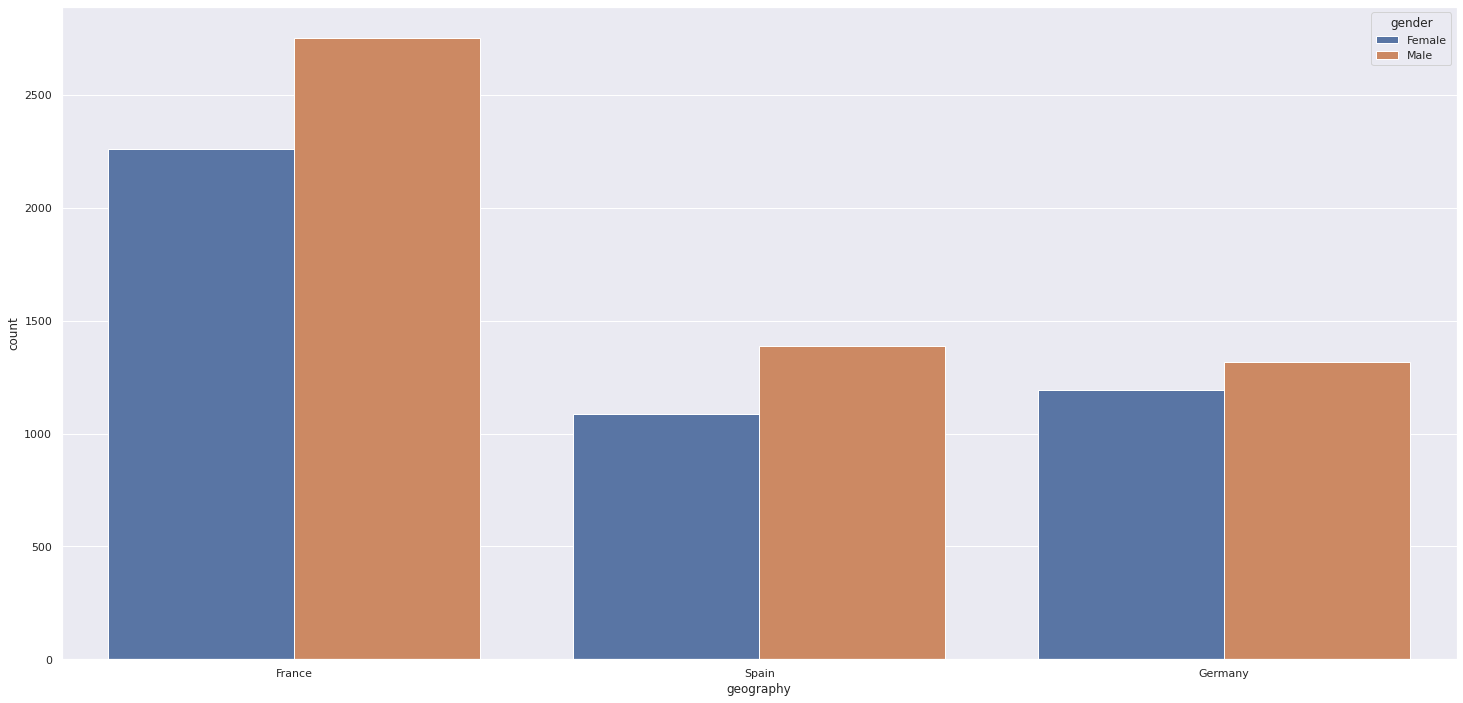

In [80]:
sns.countplot(data = cat_att, x = 'geography', hue = 'gender');

In [99]:
df1.to_csv('../data/interim/df1.csv', index = False )

# 2. Feature Engineering

In [93]:
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'active_member', 'salary', 'exited'],
      dtype='object')

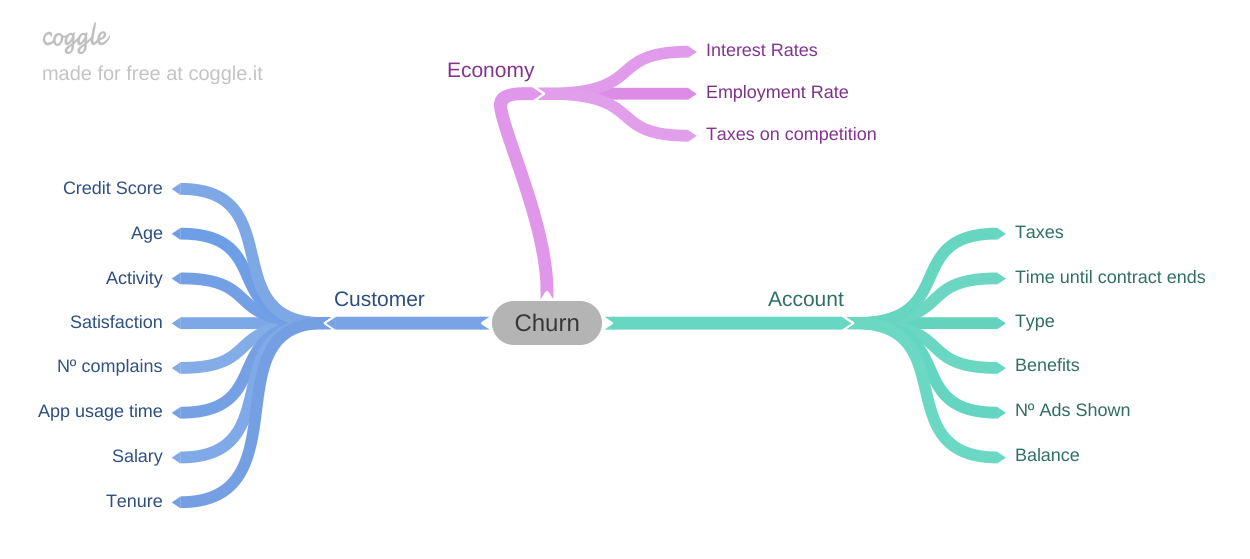

In [96]:
Image('../images/Churn.png')

### Account

Customers paying more fees churn more.

Customers with contracts closer to end churn more.

Customers with accounts more premium churn more.

Customers with more accounts bonuses (or higher tier bonuses) churn less.

**Customers with higher account balance churn less.**

Customers seeing more ads churn more.

**Customers that consume more products churn less**

### Economy.

Customers in debt churn more as interest rates go up.

Customers churn less as the employment rate increases.

Customers offered more benefits from competition churn more.

### Customer.

**Higher credit-scored customers churn less.**

**Younger customers churn more.**

More active customers churn less.

Customers with higher satisfaction churn less.

Customers that made more complaints churn more.

Customers with higher app usage time churn more.

**Customers with higher salaries churn less.**

**Customers with higher tenure churn less.**

**Country matters in customer churn**

**Genter matters in customer churn**

**Customers who have a credit card churn less**

In [86]:
df4.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'active_member', 'salary', 'exited'],
      dtype='object')

### Selected Hypothesis

**H1.** Customers with higher account balance churn less.

**H2.** Customers that consume more products churn less

**H3.** Higher credit-scored customers churn less.

**H4.** Younger customers churn more.

**H5.** Customers with higher salaries churn less.

**H6.** Customers with higher tenure churn less.

**H7.** Country matters in customer churn

**H8.** Genter matters in customer churn

**H9.** Customers who have a credit card churn less

# 3. Data Filtering

# 4. Exploratory Data Analysis

In [3]:
df4 = pd.read_csv( '../data/interim/df1.csv')

## 4.1 Univariate Analysis


### 4.1.1 Response Variable


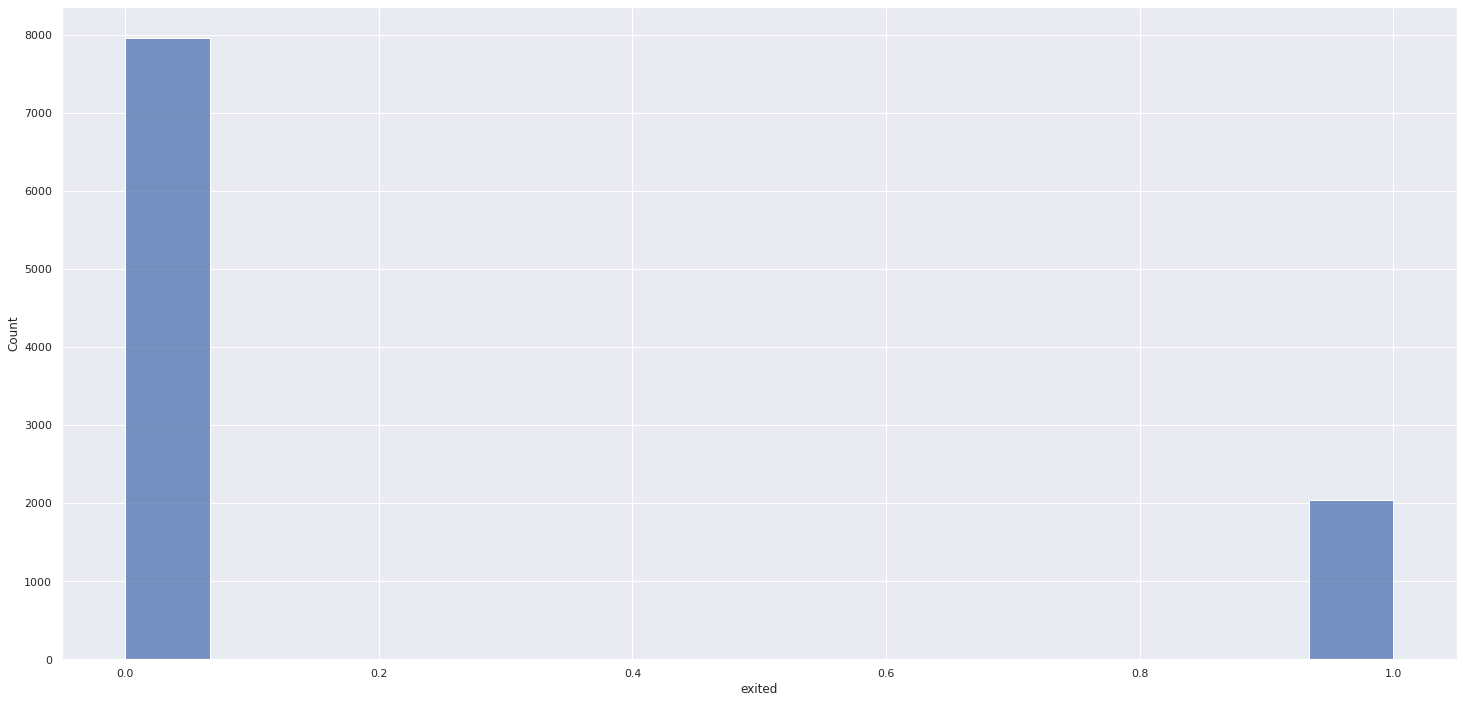

In [102]:
sns.histplot(data = df4, x = 'exited');

20% of custumers did churn

### 4.1.2 Numerical Variables


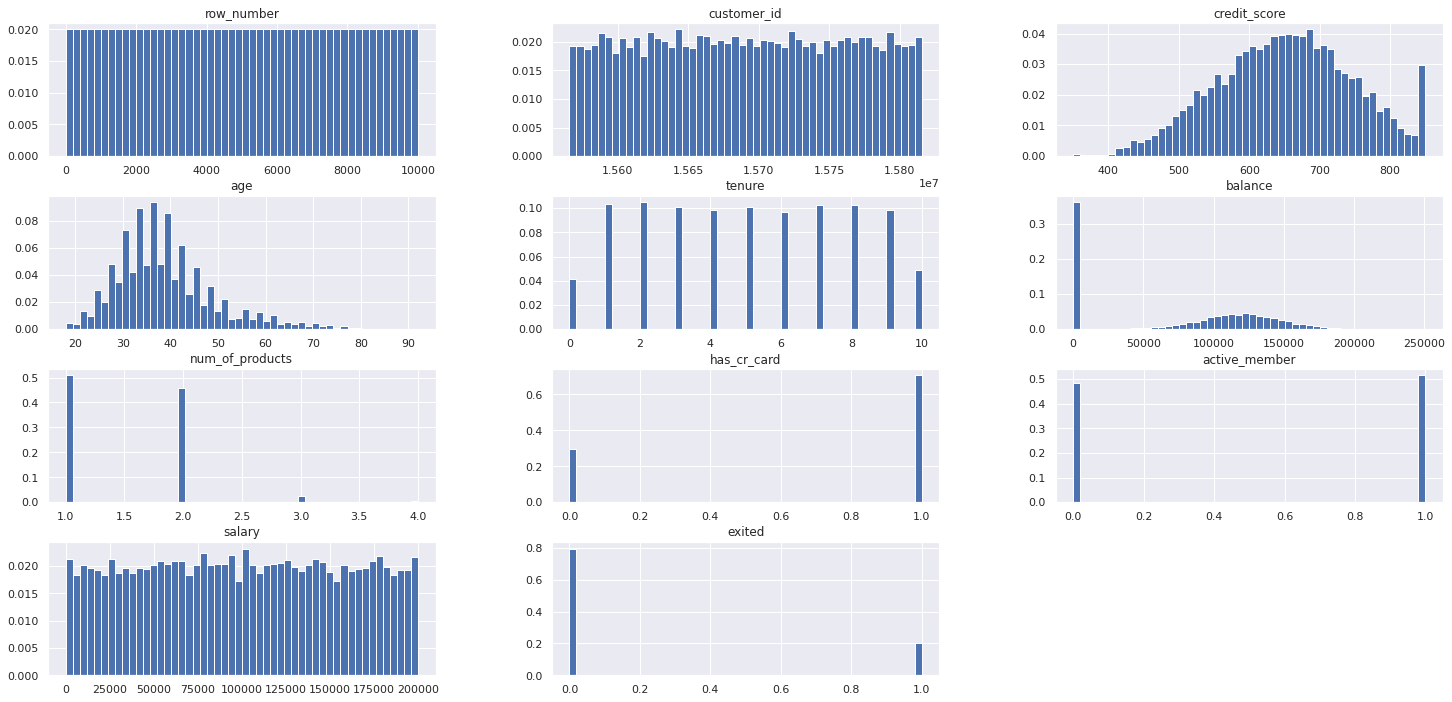

In [41]:
# weighting data with 1/n to get percentages
num_att = df4.select_dtypes(include = ['int', 'float'] )
num_att.hist( bins = 50, weights = np.ones( len(df4) )/ len(df4) );

- ### credit_score: a few customers (4%) have the highest credit score
- ### age: most customers age between 30 and 40 years old
- ### tenure: customers are evenly spred from 1 to 9 years
- ### balance: almost 40% of users have no money in their account
- ### num_of_products: very few customers consume more than 2 products
- ### has_cr_card: 30% of users have no credit card
- ### active_member: almost half of the customers has not used touched their account in the last 12 months
- ### salary: evenly distributed from 0 to $ 200,000
- ### exite: 20% of users in the dataset left churned

### 4.1.3 Categorical Variables


In [ ]:
aux1 = df1[['exited', ]]

## 4.2 Bivariate Analysis


### **H1.** Customers with higher account balance churn less.
**False**: Customers churn no matter the balance

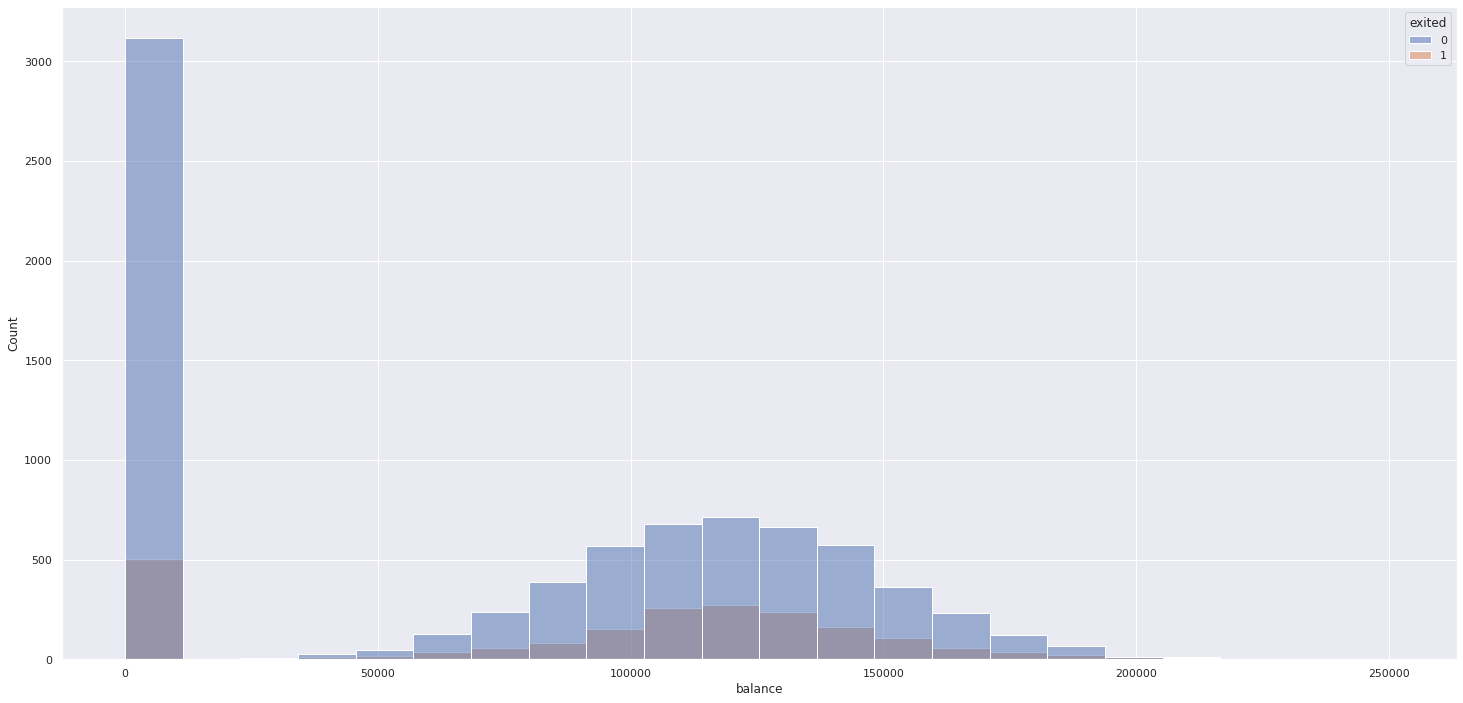

In [4]:
aux = df4[['exited', 'balance']].copy()
sns.histplot(data = aux, x = 'balance', hue = 'exited');

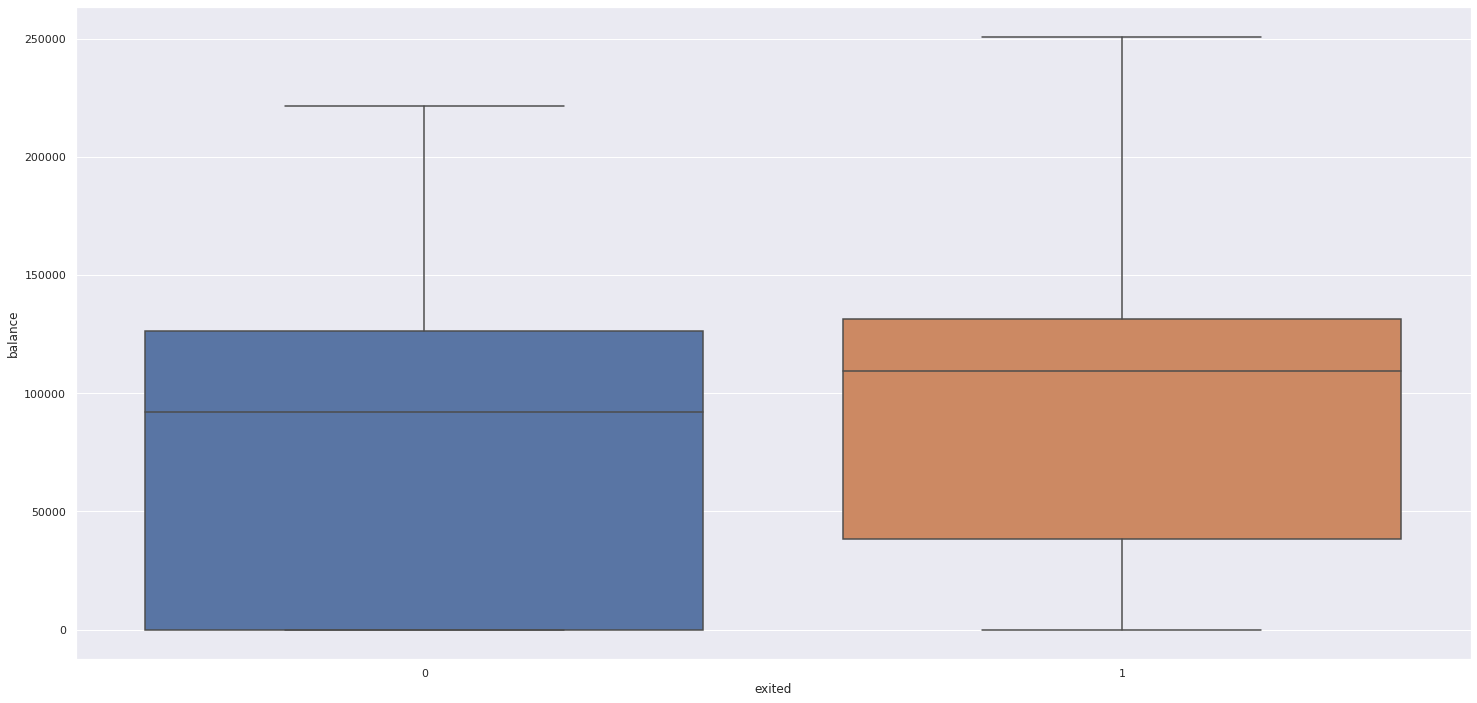

In [20]:
sns.boxplot(data = aux, x = 'exited', y = 'balance');

In [18]:
import statsmodels.api as sm

X_train = aux[['balance']]
y_train = aux[['exited']]

# the order is (y, X): endogenous/dependent, exogenous/independent
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

# I attempted to conduce a hypothesis test that showed there is no correlation between the variables

Optimization terminated successfully.
         Current function value: 0.609022
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9999
Method:                           MLE   Df Model:                            0
Date:                Mon, 22 Nov 2021   Pseudo R-squ.:                 -0.2048
Time:                        16:57:33   Log-Likelihood:                -6090.2
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance    -9.076e-06   2.42e-07    -37.574      0.000   -9.55e-06    -8.6e-06


### **H2.** Customers that consume more products churn less
**Inconclusive**: It appears customers that consume more products indeed churn less (compare 1 to 2 products' bars)

However there is a signifcant amount of customers who consume 3 or 4 products and churn, while there is not data about not churning customers consuming this amount of products.

 More data should be gattered about this before we can conclude about the assumption

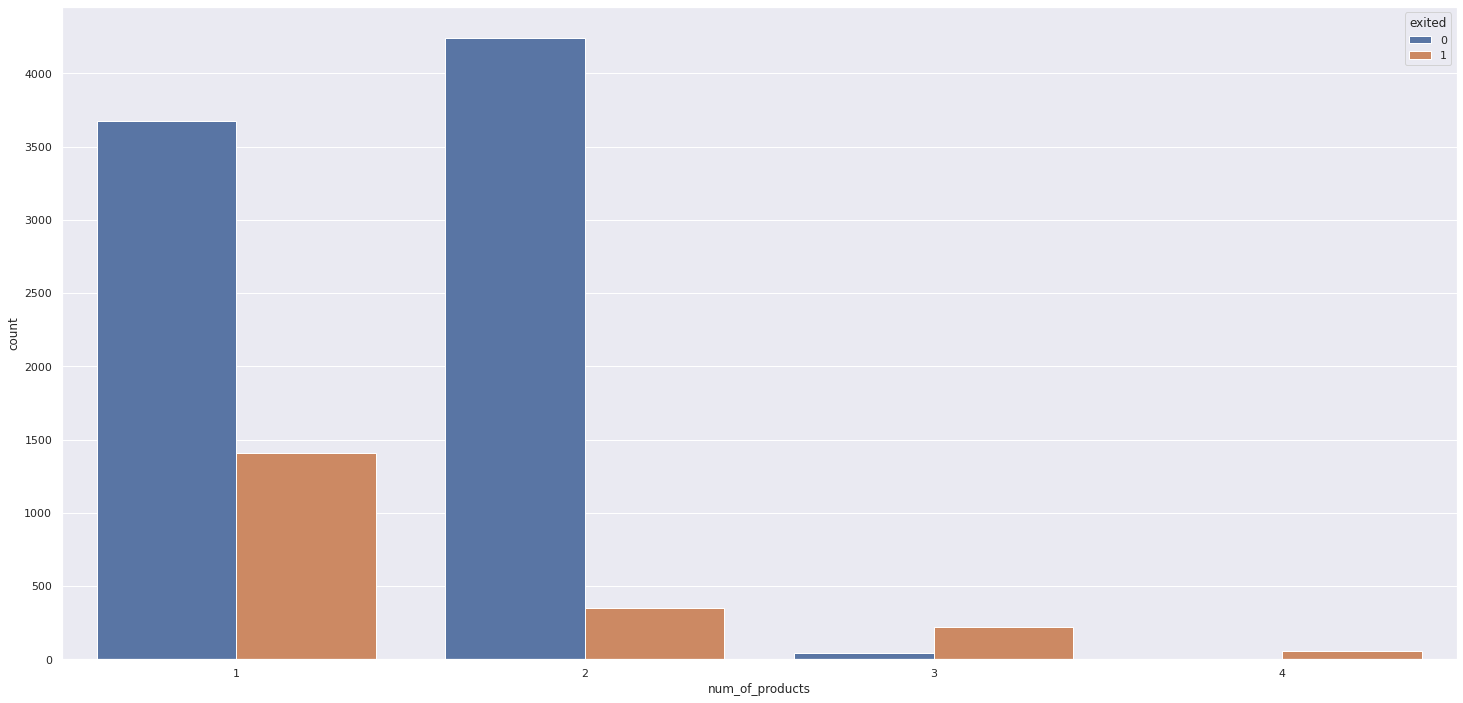

In [5]:
aux = df4[['exited', 'num_of_products']].copy()
#aux = aux.loc[ aux['num_of_products'] > 1 ]
sns.countplot(data = aux, x = 'num_of_products', hue = 'exited' );


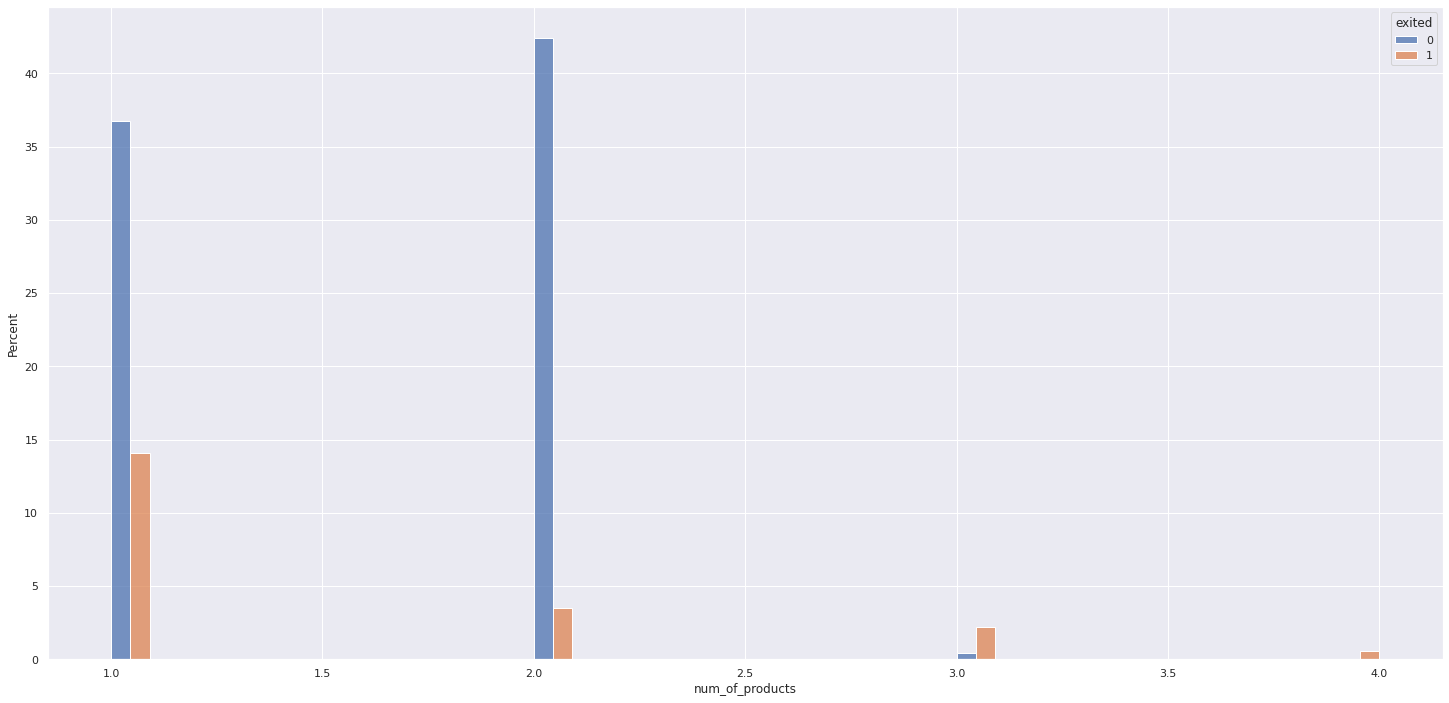

In [23]:
aux = df4[['exited', 'num_of_products']].copy()
#aux = aux.loc[ aux['num_of_products'] > 1 ]
sns.histplot(data = aux, x = 'num_of_products', hue = 'exited',  stat = 'percent', multiple = 'dodge' );


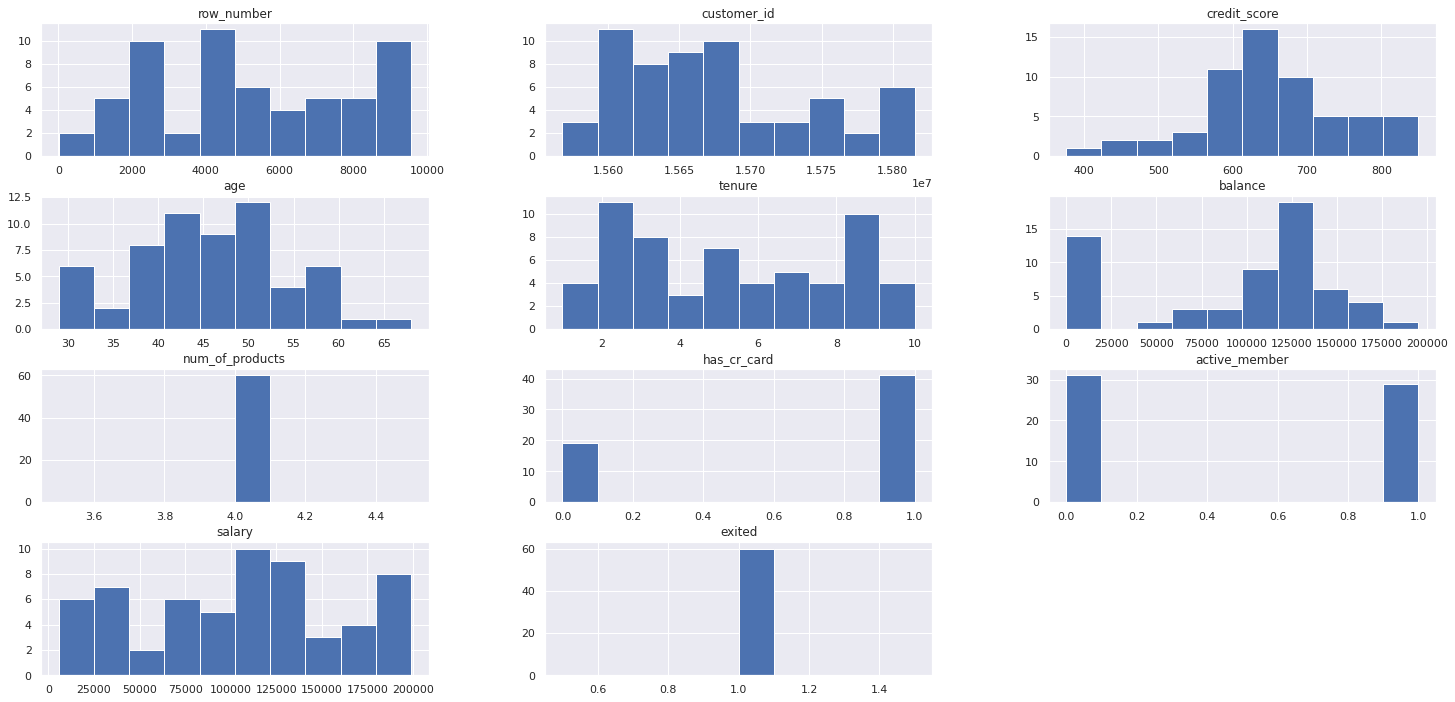

In [14]:
# investigating, nothing seems to be out of normal.
aux2 = df4.loc[ df4['num_of_products']== 4 ]
aux2.hist();

### **H3.** Higher credit-scored customers churn less.
**False**: Clients from all credit-score values are churning

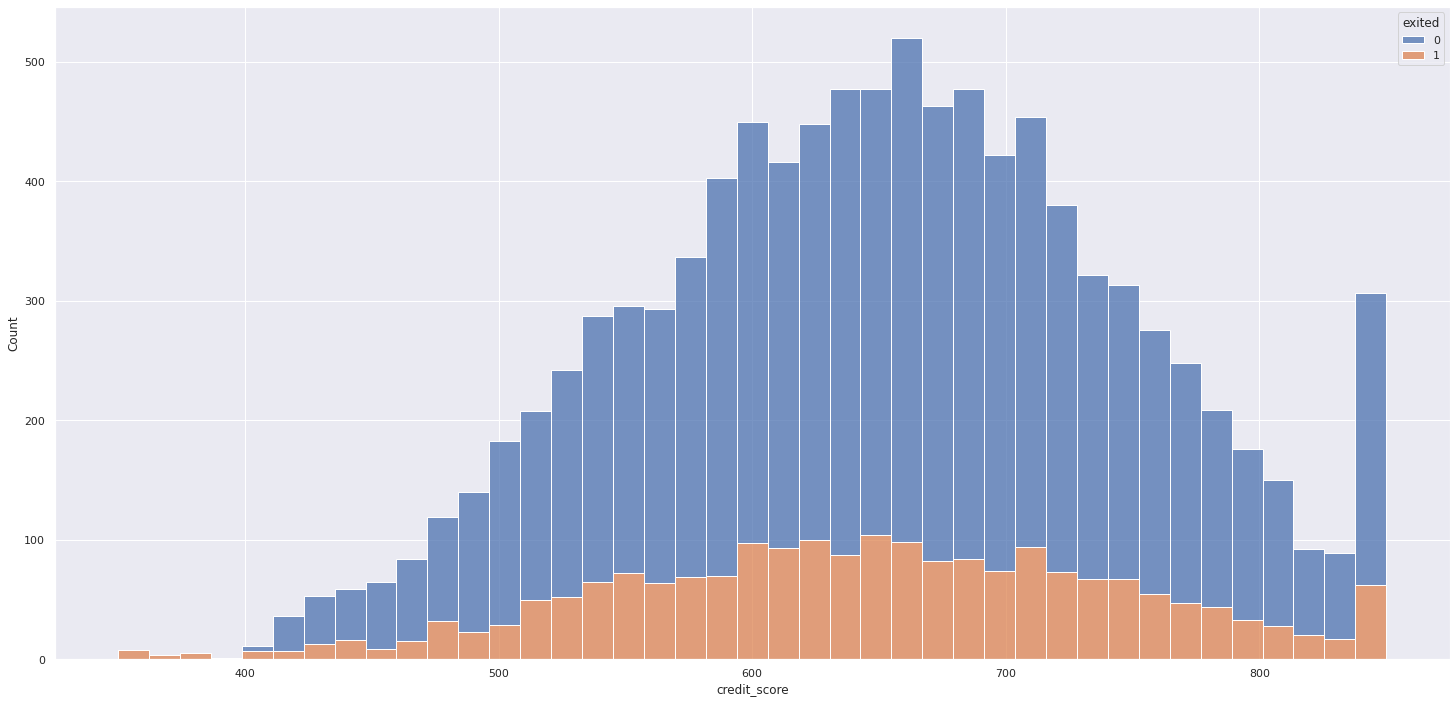

In [23]:
aux = df4[['exited', 'credit_score']]
sns.histplot(data = aux, x = 'credit_score', hue = 'exited', multiple = 'stack');

### **H4.** Younger customers churn more.
**False**: The highest percentages of churn are observed in customers above 40 years old

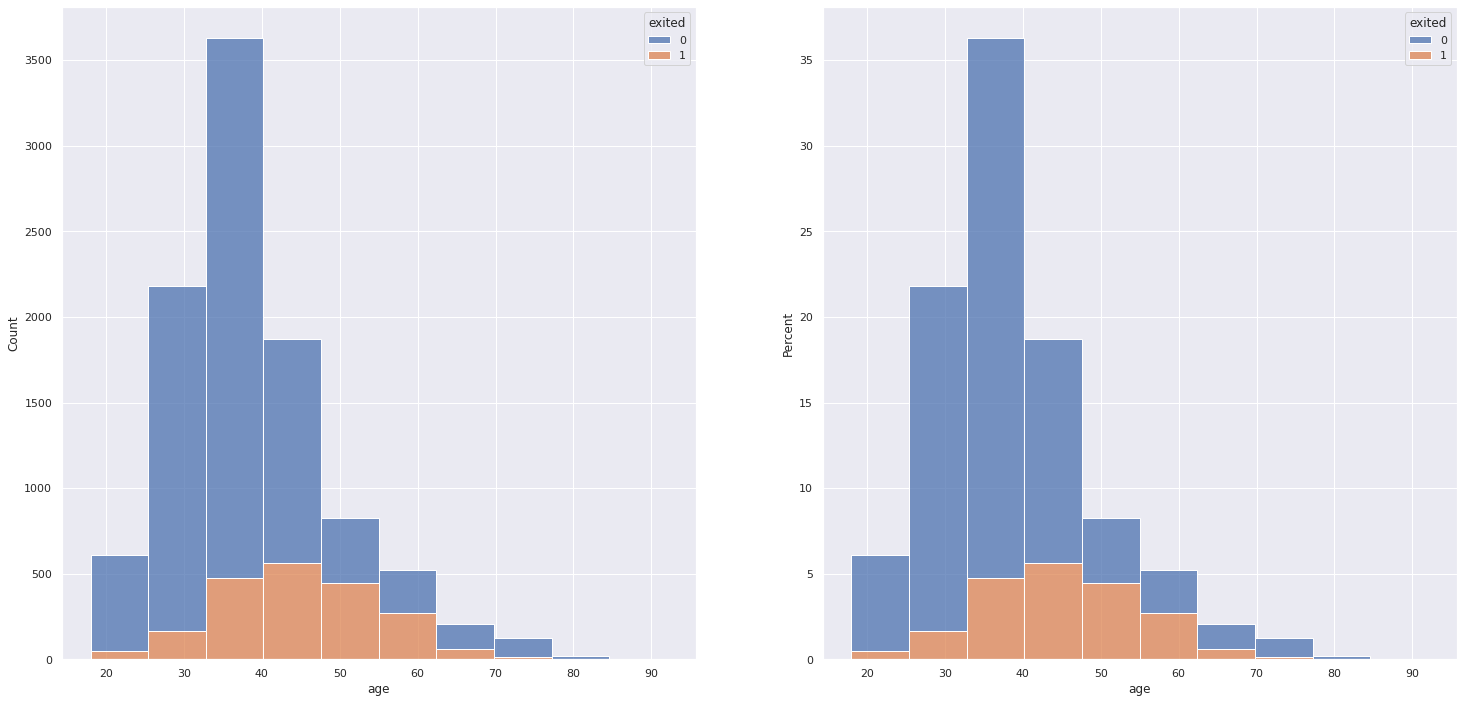

In [52]:
aux = df4[['exited', 'age']]

plt.subplot(1,2,1)
sns.histplot(data = aux, x = 'age', hue = 'exited', multiple = 'stack', bins = 10);

plt.subplot(1,2,2)
sns.histplot(data = aux, x = 'age', hue = 'exited', multiple = 'stack', stat = 'percent', bins = 10);

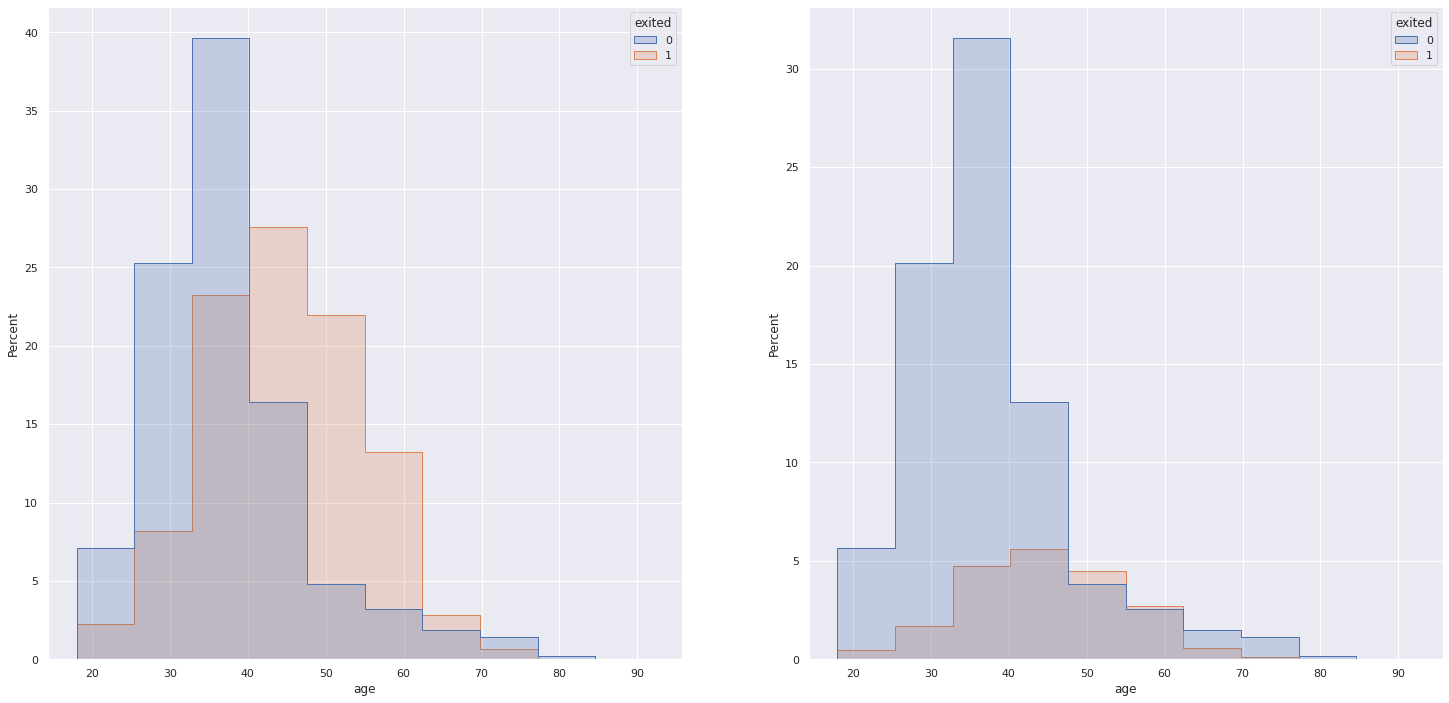

In [43]:
aux = df4[['exited', 'age']]

# Normalizes considering each class
plt.subplot(1,2,1)
sns.histplot(data = aux, x = 'age', hue = 'exited', element='step', bins = 10, stat = 'percent', common_norm= False );

# Normalizes considering all data
plt.subplot(1,2,2)
sns.histplot(data = aux, x = 'age', hue = 'exited', element='step', bins = 10, stat = 'percent', common_norm= True );

# In relative terms (considering percentage per class) customers older than 50 years old are more likely to churn

### **H5.** Customers with higher salaries churn less.
**False**: Salary appears not to be related to churn.

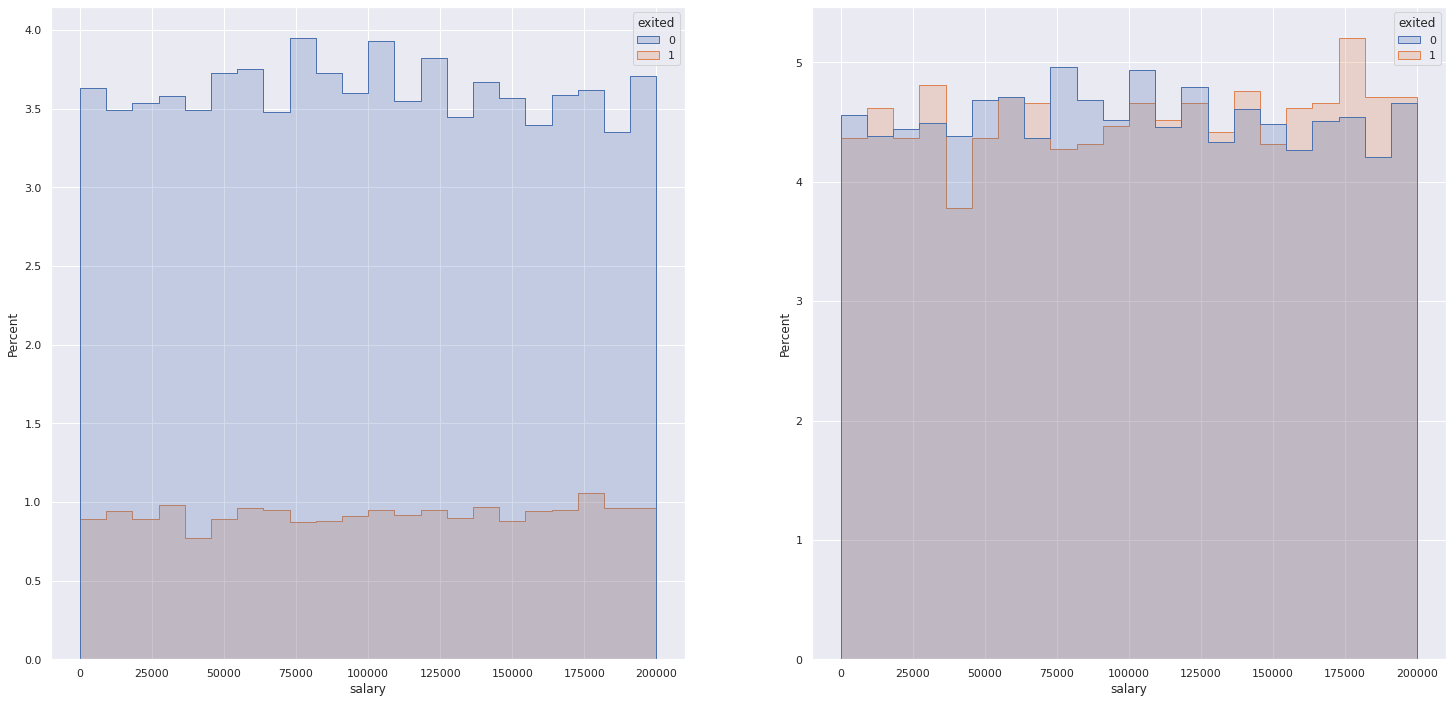

In [48]:
aux = df4[['exited', 'salary']]

#sns.boxplot(data = aux, x = 'exited', y = 'salary' );
plt.subplot(1,2,1)
sns.histplot(data = aux, x = 'salary', hue = 'exited', element = 'step', stat = 'percent' );

plt.subplot(1,2,2)
sns.histplot(data = aux, x = 'salary', hue = 'exited', element = 'step', stat = 'percent', common_norm = False );


### **H6.** Customers with higher tenure churn less.
**False**: Customers from all tenure values may churn.

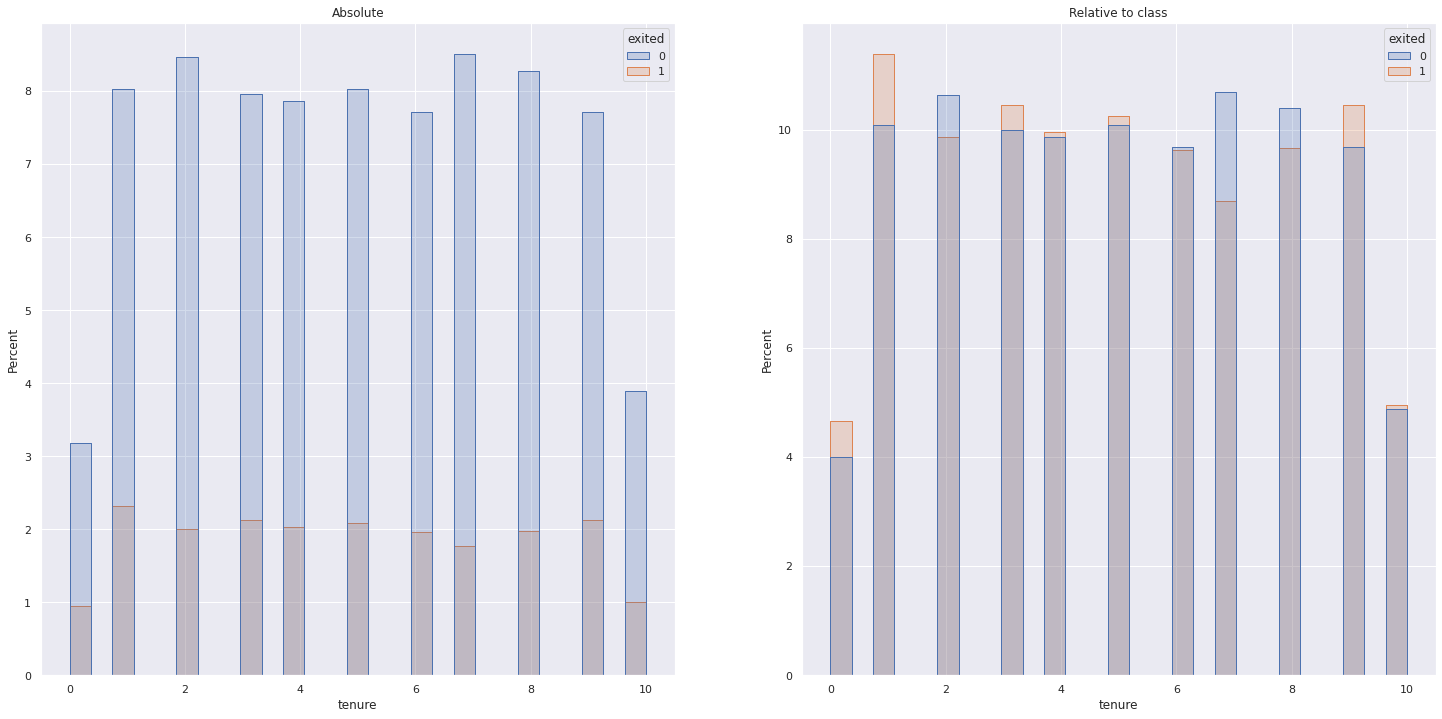

In [55]:
aux = df4[['exited', 'tenure']].copy()

plt.subplot(1,2,1)
plt.title('Absolute')
sns.histplot(data = aux, x = 'tenure', hue = 'exited', element = 'step', stat = 'percent' );

plt.subplot(1,2,2)
plt.title('Relative to class')
sns.histplot(data = aux, x = 'tenure', hue = 'exited', element = 'step', stat = 'percent', common_norm = False );

### **H7.** Country matters in customer churn
**True**: French customers present the lowest churn rates, while German customers churn a lot more

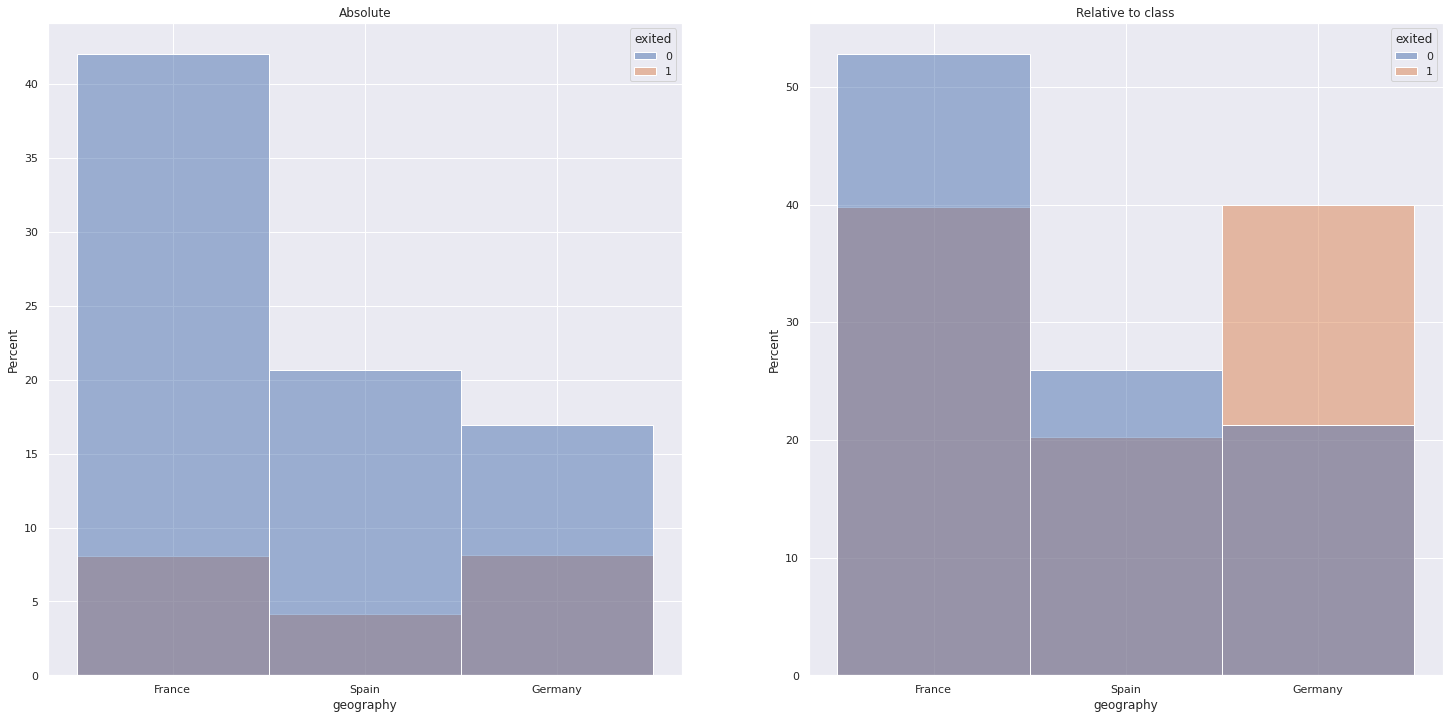

In [75]:
aux = df4[['exited', 'geography']].copy()

plt.subplot(1,2,1)
plt.title('Absolute')
sns.histplot(data = aux, x = 'geography', hue = 'exited', stat = 'percent' );

plt.subplot(1,2,2)
plt.title('Relative to class')
sns.histplot(data = aux, x = 'geography', hue = 'exited', stat = 'percent', common_norm= False );

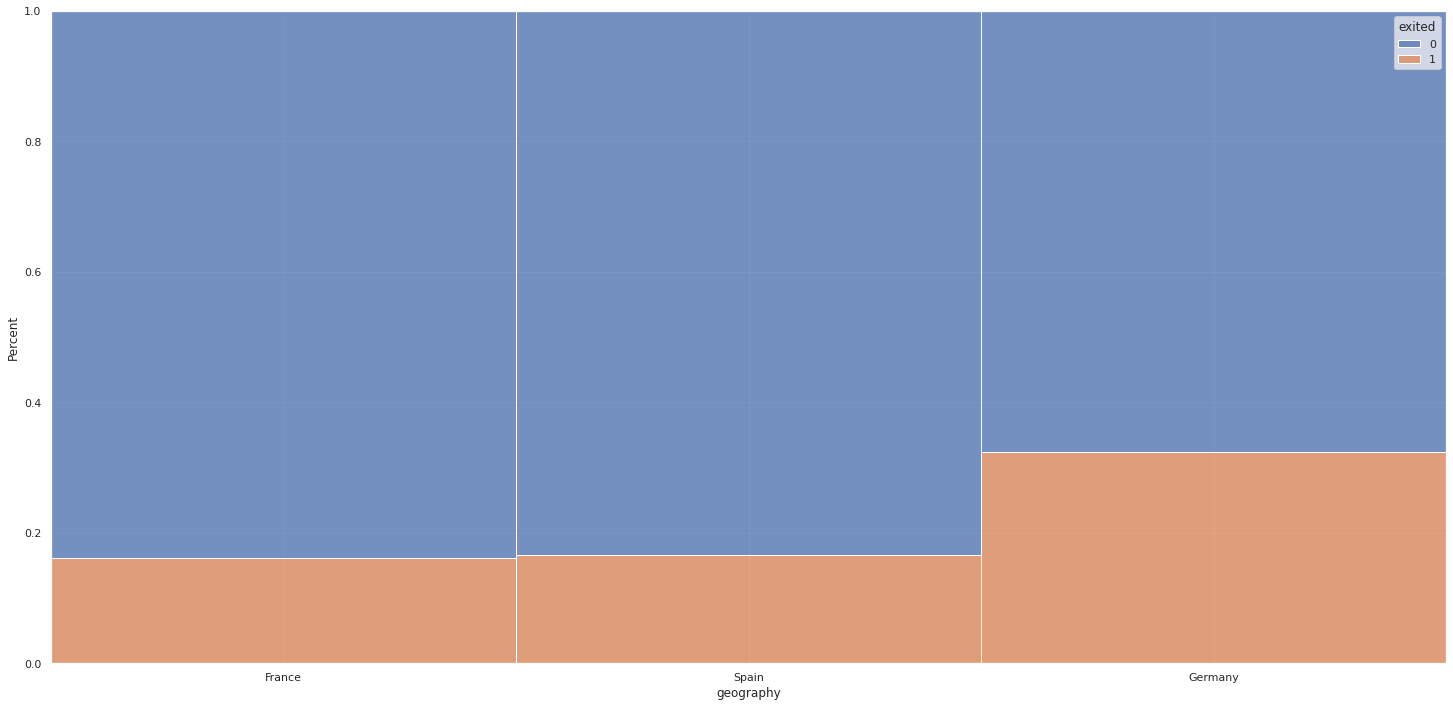

In [82]:
sns.histplot(data = aux, x = 'geography', hue = 'exited', stat= 'percent', multiple = 'fill' );
# almost 40% of German customers churned

### **H8.** Gender matters in customer churn
**True**: Female customers respond to 55% of the churns observed

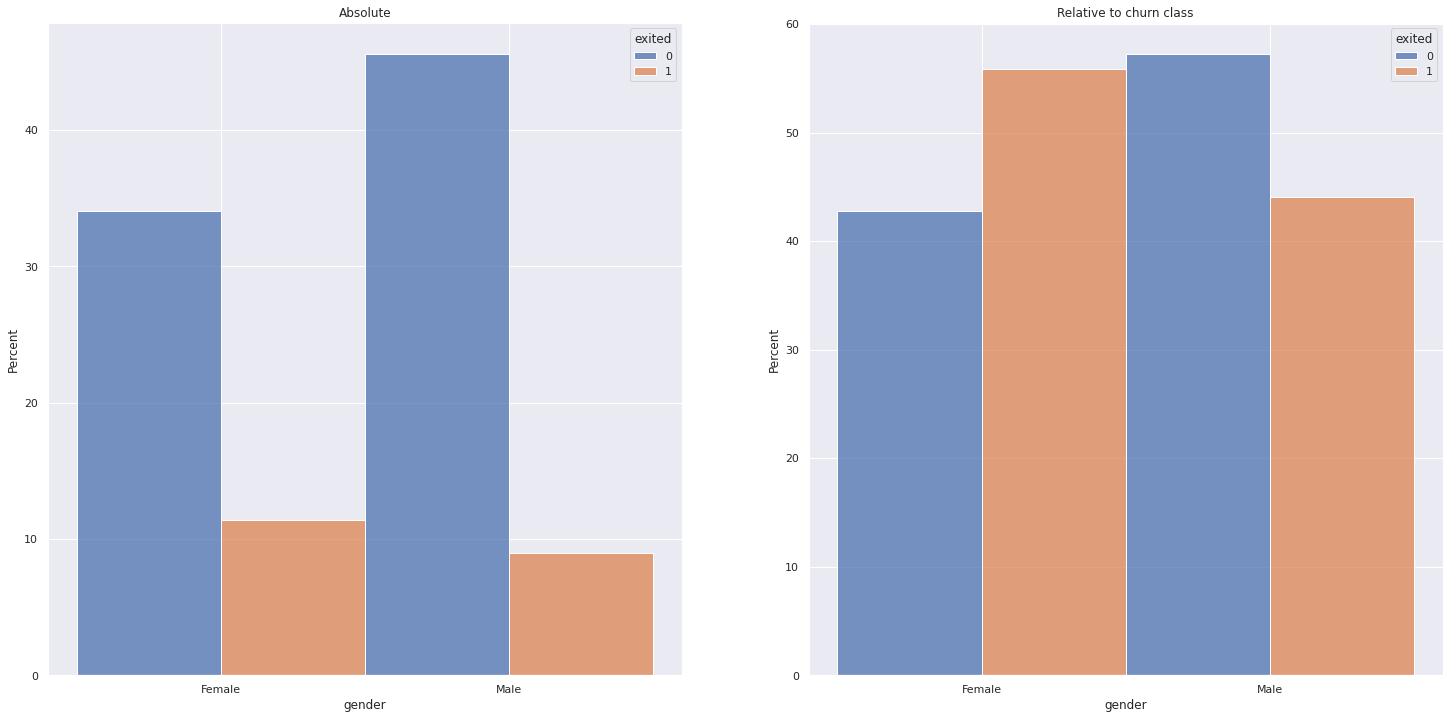

In [96]:
aux = df4[['exited', 'gender']].copy()

plt.subplot(1,2,1)
plt.title('Absolute')
sns.histplot(data = aux, x = 'gender', hue = 'exited', stat = 'percent', multiple = 'dodge' );

plt.subplot(1,2,2)
plt.title('Relative to churn class')
sns.histplot(data = aux, x = 'gender', hue = 'exited', stat = 'percent', multiple = 'dodge', common_norm= False );

### **H9.** Customers who have a credit card churn less
**False**: Churn rates are identical whether or not a customer possesses a credit card

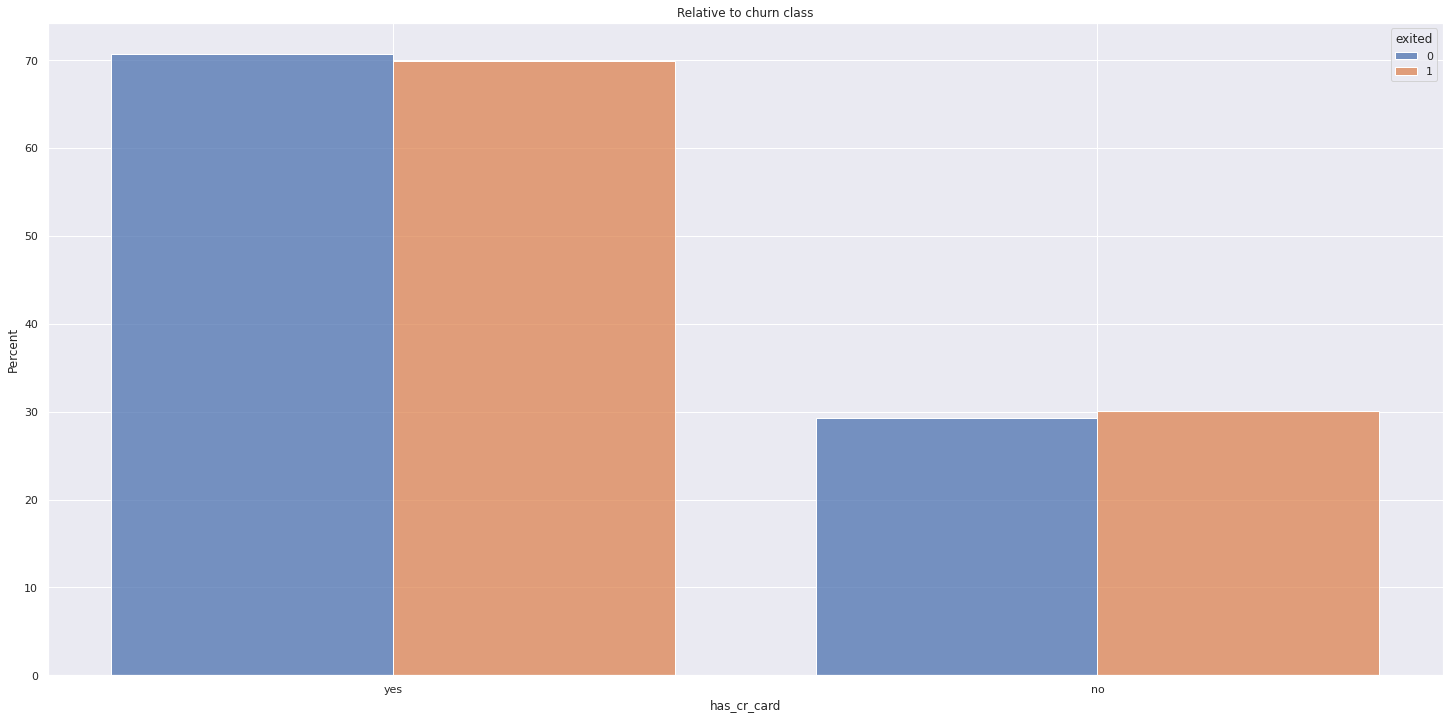

In [118]:
aux = df4[['exited', 'has_cr_card']].copy()
aux.has_cr_card = aux.has_cr_card.apply(lambda x: 'yes' if x==1 else 'no')
plt.title('Relative to churn class')
sns.histplot(data = aux, x = 'has_cr_card', hue = 'exited', multiple='dodge', stat = 'percent', common_norm= False, shrink=0.8);


    In all countries women are more likely to churn

## 4.3 Multivariate Analisys

### 4.3.1 Numerical Attributes

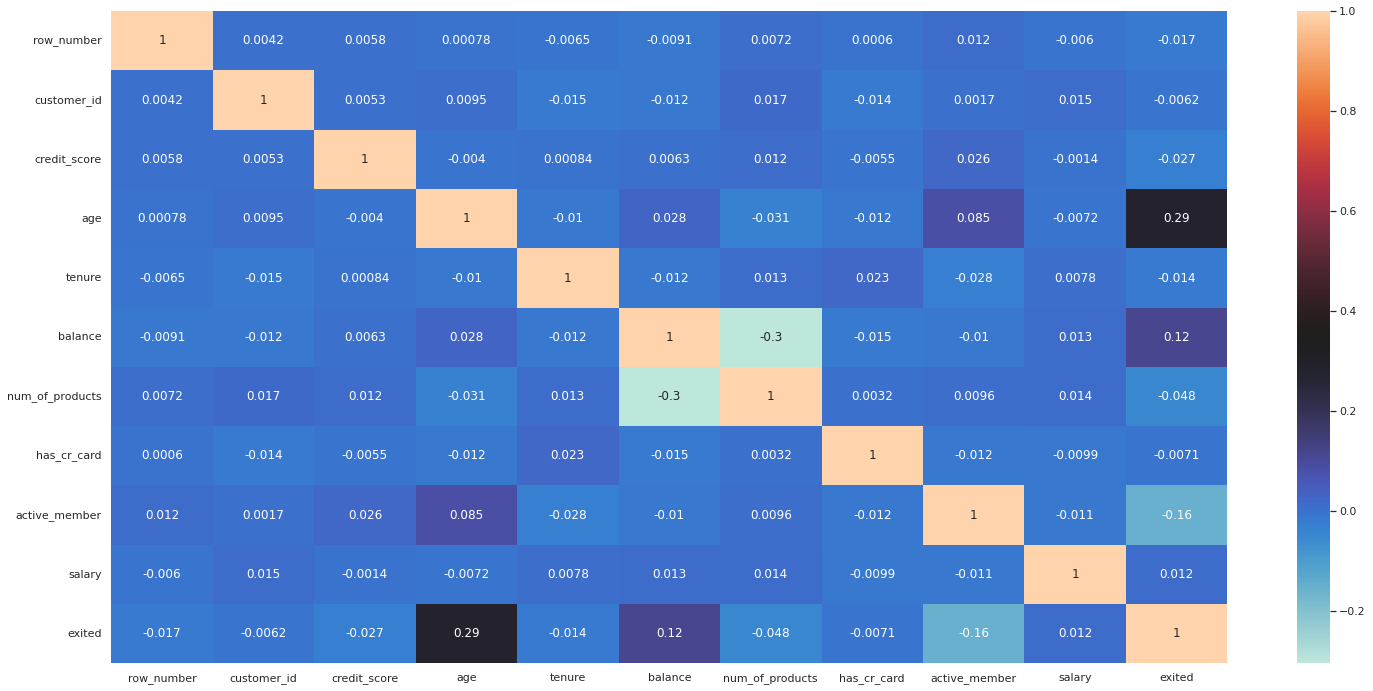

In [68]:
correlation = num_att.corr( method= 'pearson' )
sns.heatmap(correlation , annot = True, cmap = 'icefire');


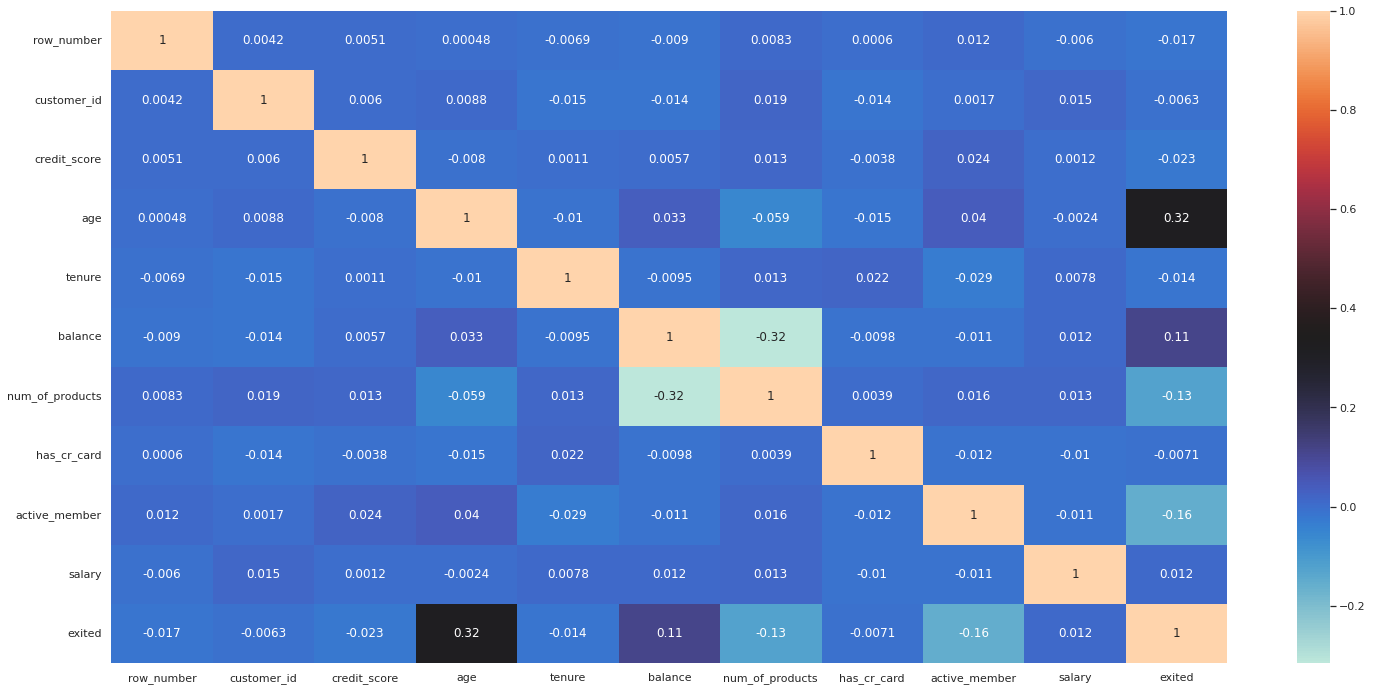

In [75]:
correlation = num_att.corr( method= 'spearman' )
sns.heatmap(correlation , annot = True, cmap = 'icefire');
# monotonic relations are not stronger than linear ones

As age increases, so does probability of churn. Same for balance.

For activity is the oposite. The more a customer utilizes their account, the less likely they are to churn, however this relationship is not very strong.

Salary, credit card, tenure and credit score show no linear or monotonic relationships

### 4.3.2 categorical Attributes

Not interested in correlation between gender and country

# 5. Data Preparation

# 6. Feature Selection

# 7. Machine Learning Modelling

# 8. Hyperparameter Fine Tunning

# 9. Convert Model Performance to Business Values

# 10. Deploy Modelo to Production